<a href="https://colab.research.google.com/github/FaffoF73/Public/blob/main/Analisi_Portafoglio_IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Regole di Acquisto e Vendita (Buy/Sell Rules):**
**Acquisto Iniziale (Initial Deployment - Solo al primo mese):**


* Il capitale iniziale e il primo contributo mensile vengono utilizzati per acquistare azioni, mirando a replicare il più fedelmente possibile i pesi target del portafoglio. Gli acquisti avvengono titolo per titolo, partendo da quelli più sottopesati, fino ad esaurimento della liquidità o al raggiungimento dei target.

**Acquisti Regolari (Mesi successivi al primo):**

* Gli acquisti sono prioritari per le Asset Class con status 'PRIORITARIO' (fortemente sottopesate) o quando lo status di liquidità del portafoglio è 'DEPLOY_ATTIVO'.
* Un singolo titolo viene acquistato se il suo peso effettivo è inferiore al suo peso target di almeno l'1% ((peso_effettivo - peso_target) <= -0.01) e se la sua Asset Class non è in stato di 'STOP_ACQUISTI' (eccessivamente sovrapesata).
* In 'Euphoria Mode' (mercato in forte rialzo), gli acquisti di titoli Growth vengono bloccati per evitare eccessiva esposizione in fasi euforiche.

**Vendita per Rebalance Soft (Annuale - Fine Dicembre):**
* Il portafoglio adotta una strategia prevalentemente Buy & Hold, ma sono consentite vendite parziali di singoli titoli esclusivamente a fine anno.
* Una vendita si attiva solo se il peso effettivo di un titolo supera del 40% il suo peso target (peso_corrente > 1.4 * peso_target).
* La quantità venduta è limitata al 25% della posizione complessiva di quel titolo.
* La regola assicura che un titolo 'core' (con peso target > 0) non venga mai venduto interamente, mantenendo almeno una quota minima.

# 2. Gestione delle Operazioni in Drawdown (Regola di Contesto di Mercato):
**Bonus sulla Crescita (Growth Bonus):** Viene applicato un bonus ai pesi target dei titoli Growth in base al drawdown del benchmark (S&P500) rispetto al suo massimo dell'anno precedente:

* Drawdown <= -25%: bonus del 3% sul peso target della classe Growth.
* Tra -25% e -15%: bonus del 2%.
* Tra -15% e -10%: bonus dell'1%.

Questo rende i titoli Growth più attraenti per l'acquisto durante le fasi di ribasso del mercato.

**Modalità Euforia (Euphoria Mode):** Si attiva se la performance YTD del benchmark supera il +15%. In questa modalità, non sono consentiti acquisti di titoli Growth, per evitare di sovraesporre il portafoglio in fasi di eccessivo ottimismo.

# 3. Gestione della Liquidità:
**Contributi Mensili:** Ogni mese vengono aggiunti €300 alla cassa del portafoglio.

**Reinvestimento Dividendi (Annuale - Fine Dicembre):** I dividendi netti (calcolati dopo le tassazioni estere e italiane applicabili) vengono automaticamente aggiunti alla cassa e sono quindi disponibili per futuri acquisti o per il rebalance.

**Status di Liquidità del Portafoglio:** Determina la propensione all'acquisto:
* '**SOSPENSION_NON_ESSENZIALI**': Se il peso della cassa è inferiore al target, gli acquisti non essenziali vengono sospesi - **TUTTI gli acquisti sono sospesi fino al raggiungimento del target di cassa** (peso target + margine di intervento). L'obiettivo principale è conservare la liquidità e permettere alla riserva di cassa di ricostituirsi, sia tramite i contributi mensili, sia tramite i dividendi, o semplicemente evitando nuovi investimenti. Anche se un titolo o un'asset class dovessero apparire molto attraenti, il sistema non effettuerà acquisti per **proteggere la liquidità**.
* '**OPERATIVITA_NORMALE**': Se il peso della cassa è in linea con il target, le operazioni di acquisto avvengono normalmente.
* '**DEPLOY_ATTIVO**': Se il peso della cassa supera la soglia massima (>7% del totale portafoglio), il sistema cerca attivamente di allocare la liquidità, rendendo gli acquisti più aggressivi.

# **Simulazione IPS**

In [10]:
## BLOCCO 1: IMPORTS E CONFIGURAZIONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
import seaborn as sns

In [11]:
## BLOCCO 1: IMPORTS E CONFIGURAZIONE CON PROXY MAP

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

## BLOCCO 2: DEFINIZIONE PORTAFOGLIO E PROXY SYSTEM

# --- 1. CONFIGURAZIONE ASSET E PROXY ---
# Per estendere il backtesting al passato, definiamo dei PROXY per i titoli recenti.
# Se un titolo non ha dati in una certa data, prenderà l'andamento percentuale del suo proxy.
# Sintassi: "TICKER_PORTAFOGLIO": "TICKER_PROXY"
# Nota: Usa indici liquidi o competitor storici come proxy.
PROXY_MAP = {
    "RWAY.MI": "VZ",    # Rway (rinnovabili) simulata con Enel nel passato
    "NVO": "PFE",            # Novo Nordisk simulata con Eli Lilly (o viceversa se mancano dati)
    "1ASML.MI": "^IXIC",      # ASML Milano simulata con ASML US o Amsterdam
    "RACE.MI": "^SPX",       # Ferrari (quotata 2015) simulata con S&P500 (o un indice Auto se esiste)
    "SGLD.MI": "GLD",        # ETF Oro Milano simulato con GLD US (storico più lungo)
    "GOOGL": "GOOGL",
    "AMZN": "AMZN",
    "MSFT": "MSFT",
    "NVO": "NVO",
    "LLY": "LLY",
    "RIO.L": "RIO.L",
    "ULVR.L": "ULVR.L",
    "ENI.MI": "ENI.MI",
    "ISP.MI": "ISP.MI",
    "PHP.L": "PHP.L"
    # I titoli che non hanno un proxy specifico useranno il BENCHMARK generale come fallback
}

# --- PORTFOLIO ATTUALE Quota di portafoglio e dividend yield
assets = [
    ["GOOGL",    "USD", 0.07, "GROWTH", 0.003],["AMZN",     "USD", 0.07, "GROWTH", 0],["MSFT",     "USD", 0.07, "GROWTH", 0.008],["NVO",      "USD", 0.06, "GROWTH", 0.0161],["RACE.MI",  "EUR", 0.07, "GROWTH", 0.006],["LLY",      "USD", 0.05, "GROWTH", 0.0097],
    ["RIO.L",    "GBP", 0.10, "VALUE", 0.045],["ULVR.L",   "GBP", 0.10, "VALUE", 0.035],["ENI.MI",   "EUR", 0.10, "VALUE", 0.062],["ISP.MI",   "EUR", 0.10, "VALUE", 0.072],["RWAY.MI",  "EUR", 0.06, "VALUE", 0.0522],["SGLD.MI",  "EUR", 0.08, "HEDGE", 0],["1ASML.MI", "EUR", 0.07, "GROWTH", 0.01],
]



benchmark_info = ["^SPX", "USD"]
cash_iniziale = 38000
cash_mensile_iniziale= 300
cash_monthly_increase = 0.05

# Parametri Temporali ESTESI (Per testare il bear market)
inizio = "2020-01-01" # <--- Impostato molto indietro per testare crisi 2008
fine = "2026-01-31"


# ---1. INFORMAZIONI PER IL CALCOLO DEI DIVIDENDI
ANNUAL_DIVIDEND_GROWTH_RATE = 0.02  # Esempio: 2% di crescita annuale dei dividendi
FOREIGN_TAX_RATE_USD = 0.15         # Esempio: 15% di tassa estera sui dividendi USD
ITALIAN_TAX_RATE = 0.26             # Esempio: 26% di tassa italiana sui dividendi

# Costruzione di stock_detailed_info dal tuo 'assets' list
stock_detailed_info = {
    row[0]: {'Currency': row[1], 'Dividend_Yield': row[4]}
    for row in assets
}

# --- 2. GENERAZIONE AUTOMATICA VARIABILI ---
portafoglio = [row[0] for row in assets]
asset_currencies_raw = {row[0]: row[1] for row in assets}
asset_class_map = {row[0]: row[3].capitalize() for row in assets}

# --- 3. RICALCOLO DINAMICO DEI PESI (Invariato) ---
target_ac_weights = {'Growth': 0.42, 'Value': 0.42, 'Hedge': 0.10, 'Cash_Min': 0.06, 'Cash_Max': 0.10}
df_assets = pd.DataFrame(assets, columns=['Ticker', 'Currency', 'Orig_Weight', 'AC', 'Dividend_Yield'])
df_assets['AC'] = df_assets['AC'].str.capitalize()
sum_orig_by_ac = df_assets.groupby('AC')['Orig_Weight'].transform('sum')
df_assets['Relative_Inside_AC'] = df_assets['Orig_Weight'] / sum_orig_by_ac
df_assets['Final_Weight'] = df_assets.apply(lambda x: x['Relative_Inside_AC'] * target_ac_weights.get(x['AC'], 0), axis=1)
pesi_portafoglio_attuale = df_assets['Final_Weight'].values
nomi_asset = df_assets['Ticker'].tolist()

print(f"Backtest impostato dal {inizio} al {fine}")

# --- 4. SCARICO E PULIZIA DATI AVANZATA ---
benchmark_ticker = benchmark_info[0]
asset_currencies_raw[benchmark_ticker] = benchmark_info[1]

# Lista completa download: Asset + Benchmark + Proxy
proxy_tickers = list(set(PROXY_MAP.values()))
tickers_totali = list(set(nomi_asset + [benchmark_ticker] + proxy_tickers))

print(f"\nScaricamento dati per {len(tickers_totali)} ticker (inclusi proxy)...")
# Scarichiamo con 'auto_adjust=True' per gestire split e dividendi storici sui prezzi
dati_raw = yf.download(tickers_totali, start=inizio, end=fine, auto_adjust=True)['Close']


# Scaricamento Cambi (Esteso anche ai proxy se necessario, ma semplifichiamo ai principali)
exchange_tickers = ["EURUSD=X", "GBPEUR=X"]
exchange_rates = yf.download(exchange_tickers, start=inizio, end=fine, auto_adjust=True)['Close']
exchange_rates = exchange_rates.ffill().bfill()

# --- 5. LOGICA DI BACKFILL SINTETICO (CORE DEL CAMBIAMENTO) ---
dati_filled = dati_raw.copy()
first_valid_idx_df = dati_filled.first_valid_index()

print("\n--- INIZIO RICOSTRUZIONE STORICI MANCANTI ---")

for ticker in nomi_asset:
    print("First valid index: ", dati_filled[ticker].first_valid_index(), " prima data valida dataframe: ", first_valid_idx_df ," - Inizio: ",pd.to_datetime(inizio).tz_localize(dati_filled.index.tz))
    first_valid_idx = dati_filled[ticker].first_valid_index()
    proxy = PROXY_MAP.get(ticker, benchmark_ticker)

    # Check if proxy exists and has data. If not, we can't use it.
    if proxy not in dati_filled.columns or dati_filled[proxy].first_valid_index() is None:
        print(f"  -> AVVISO: Proxy {proxy} per {ticker} non trovato o senza dati. Impossibile backfill.")
        # If both ticker and its proxy are completely missing, the column will remain NaN.
        continue # Skip to next ticker

    proxy_series = dati_filled[proxy]

    if first_valid_idx is None:
        # Original ticker has NO data for the entire period. Use proxy for full history.
        print(f"Backfilling COMPLETO per {ticker} usando proxy: {proxy}")
        # Direct substitution. Assumes the proxy's raw values are a reasonable stand-in.
        dati_filled[ticker] = proxy_series
    #elif first_valid_idx > pd.to_datetime(inizio).tz_localize(dati_filled.index.tz):
    elif first_valid_idx > first_valid_idx_df :
        # Original ticker has data, but starts later. Fill the initial gap.
        print(f"Backfilling PARZIALE per {ticker} (Dati dal {first_valid_idx.date()}) usando proxy: {proxy}")

        anchor_price_asset = dati_filled.loc[first_valid_idx, ticker]

        try:
            anchor_price_proxy = proxy_series.asof(first_valid_idx)
        except:
            anchor_price_proxy = np.nan

        if not pd.isna(anchor_price_proxy) and anchor_price_proxy != 0:
            scale_factor = anchor_price_asset / anchor_price_proxy
            synthetic_history = proxy_series * scale_factor
            dati_filled[ticker] = dati_filled[ticker].combine_first(synthetic_history)
        else:
            print(f"  -> ATTENZIONE: Impossibile usare proxy {proxy} per riempire {ticker} (dati parziali): dati proxy mancanti o zero alla data di ancoraggio.")
    else:
        print(f"Backfilling NON OPERATO per {ticker} (Dati disponibili dal {first_valid_idx.date()})")

# --- 6. CONVERSIONE VALUTA (Sui dati "Rippati") ---
# Ora che abbiamo riempito i buchi (in valuta originale), convertiamo tutto in EUR
dati_eur = dati_filled.copy()
common_dates = dati_eur.index.intersection(exchange_rates.index)

# Nota: per la conversione dobbiamo assicurarci che anche i cambi coprano il periodo storico.
# Abbiamo usato ffill/bfill sui cambi, quindi dovremmo essere coperti.

for ticker in tickers_totali:
    if ticker not in dati_eur.columns: continue
    # Se è un proxy puro non in portafoglio, potremmo saltarlo, ma convertiamo tutto per sicurezza
    curr = asset_currencies_raw.get(ticker, "EUR") # Default EUR se non specificato

    if curr == "USD":
        dati_eur.loc[common_dates, ticker] /= exchange_rates.loc[common_dates, 'EURUSD=X']
    elif curr == "GBP":
        dati_eur.loc[common_dates, ticker] = (dati_eur.loc[common_dates, ticker] / 100) * exchange_rates.loc[common_dates, 'GBPEUR=X']

# --- 7. DATI FINALI CLEAN ---
# Selezioniamo solo le colonne del portafoglio reale e del benchmark (scartiamo le colonne dei proxy puri)
cols_to_keep = nomi_asset + [benchmark_ticker]
dati_ptf_final = dati_eur[cols_to_keep].dropna()

# Resample Mensile
dati_monthly = dati_ptf_final.resample('ME').last() # Pandas pandas >= 2.2.0 usa 'ME'

print(f"\n--- ELABORAZIONE COMPLETATA ---")
print(f"Dati portfolio pronti: {dati_ptf_final.shape[0]} giorni.")
print(f"Copertura temporale effettiva: dal {dati_ptf_final.index[0].date()} al {dati_ptf_final.index[-1].date()}")

Backtest impostato dal 2020-01-01 al 2026-01-31

Scaricamento dati per 18 ticker (inclusi proxy)...


[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  2 of 2 completed


--- INIZIO RICOSTRUZIONE STORICI MANCANTI ---
First valid index:  2020-01-02 00:00:00  prima data valida dataframe:  2020-01-02 00:00:00  - Inizio:  2020-01-01 00:00:00
Backfilling NON OPERATO per GOOGL (Dati disponibili dal 2020-01-02)
First valid index:  2020-01-02 00:00:00  prima data valida dataframe:  2020-01-02 00:00:00  - Inizio:  2020-01-01 00:00:00
Backfilling NON OPERATO per AMZN (Dati disponibili dal 2020-01-02)
First valid index:  2020-01-02 00:00:00  prima data valida dataframe:  2020-01-02 00:00:00  - Inizio:  2020-01-01 00:00:00
Backfilling NON OPERATO per MSFT (Dati disponibili dal 2020-01-02)
First valid index:  2020-01-02 00:00:00  prima data valida dataframe:  2020-01-02 00:00:00  - Inizio:  2020-01-01 00:00:00
Backfilling NON OPERATO per NVO (Dati disponibili dal 2020-01-02)
First valid index:  2020-01-02 00:00:00  prima data valida dataframe:  2020-01-02 00:00:00  - Inizio:  2020-01-01 00:00:00
Backfilling NON OPERATO per RACE.MI (Dati disponibili dal 2020-01-02)


In [12]:
### BLOCCO 3 CORRETTO E PULITO

# --- 1. FUNZIONI DI SUPPORTO ---

total_init_deploy= False

def get_market_context(current_bench_price, ref_peak_price, ytd_start_bench_price):
    """
    Applica la Regola 2: CONTESTO DI MERCATO
    ref_peak_price: Deve essere il massimo dell'anno precedente (o corrente se è il 1° anno)
    """
    # Evitiamo divisioni per zero
    if ref_peak_price <= 0:
        drawdown = 0.0
    else:
        drawdown = (current_bench_price / ref_peak_price) - 1

    # Calcolo YTD Performance
    ytd_perf = (current_bench_price / ytd_start_bench_price) - 1

    growth_bonus = 0.0
    is_euphoria = False

    # Logica Drawdown (Bonus tattico su Growth)
    if drawdown <= -0.25:
        growth_bonus = 0.03
    elif -0.25 < drawdown <= -0.15:
        growth_bonus = 0.02
    elif -0.15 < drawdown <= -0.10:
        growth_bonus = 0.01

    # Logica Euforia
    if ytd_perf >= 0.15:
        is_euphoria = True

    return growth_bonus, is_euphoria

#se cash <4% SOSPENSION_NON_ESSENZIALI, se >7% DEPLOY ATTIVO, ovvero scarica liquidità, in tutti gli altri casi OPERATIVITA_NORMALE
def get_liquidity_status(cash_weight, target_cash_min, target_cash_max):
    if cash_weight < target_cash_min: return "SOSPENSION_NON_ESSENZIALI"
    elif target_cash_min <= cash_weight <= target_cash_max: return "OPERATIVITA_NORMALE"
    else: return "DEPLOY_ATTIVO"

def get_asset_class_status(current_w, target_w, growth_bonus=0.0):
    adjusted_target = target_w + growth_bonus
    diff = current_w - adjusted_target
    if diff <= -0.03: return "PRIORITARIO"
    if -0.03 < diff <= -0.02: return "PRE_ALLERTA"
    if diff >= 0.03: return "STOP_ACQUISTI"
    if 0.02 <= diff < 0.03: return "CAUTELA"
    return "FISIOLOGICO"

# se è un titolo Growth E il mercato è euforico NON SI OPERA, altrimenti restituisce VERO se il titolo è sottopeso dell'1% dal peso target e se non c'è lo stop all'acquisto
def can_buy_stock(stock_w, target_w, ac_status, euphoria, is_growth):
    if euphoria and is_growth: return False
    return ((stock_w - target_w) <= -0.01) and (ac_status != "STOP_ACQUISTI")

# --- 2. MOTORE DI SIMULAZIONE (MODIFICATO) ---

def esegui_simulazione_ips(prices_df, benchmark_series, initial_cash, initial_monthly_add, monthly_add_increase, target_weights_stocks, target_weights_ac, ac_map, stock_detailed_info, annual_div_growth_rate, foreign_tax_rate_usd, italian_tax_rate):
    dates = prices_df.index
    tickers = list(prices_df.columns)
    history = []
    total_period_inv_dividends = 0
    cash = initial_cash
    shares = {t: 0 for t in tickers}
    stock_targets = dict(zip(tickers, target_weights_stocks))

    # --- NUOVA GESTIONE MASSIMI ANNUALI ---
    # Dizionario per salvare il massimo raggiunto in ogni anno: {2020: 4500, 2021: 4800, ...}
    yearly_highs = {}

    # Inizializziamo il YTD start
    ytd_start_bench = benchmark_series.iloc[0]
    last_year = dates[0].year

    for i in range(len(dates)):
        year = int(i/12) #indica il progressivo dell'anno (0 = primo anno, 1= secondo anno, ecc.)
        current_date = dates[i]
        curr_year = current_date.year
        prices = prices_df.iloc[i]
        bench_price = benchmark_series.iloc[i]

        # 1. Aggiornamento Massimo dell'Anno Corrente
        if curr_year not in yearly_highs:
            yearly_highs[curr_year] = 0.0
        if bench_price > yearly_highs[curr_year]:
            yearly_highs[curr_year] = bench_price

        # 2. Definizione del Prezzo di Riferimento (Picco) per il Drawdown
        # Se esiste l'anno precedente, usiamo il suo massimo.
        # Altrimenti (siamo nel primo anno), usiamo il massimo corrente progressivo.
        prev_year = curr_year - 1
        if prev_year in yearly_highs:
            reference_peak = yearly_highs[prev_year]
        else:
            reference_peak = yearly_highs[curr_year]

        # 3. Gestione YTD (Reset a Gennaio)
        if curr_year != last_year:
            ytd_start_bench = bench_price
            last_year = curr_year

        # --- CALCOLO CONTESTO ---
        # Passiamo 'reference_peak' che ora è il MAX DELL'ANNO PRECEDENTE
        growth_bonus, is_euphoria = get_market_context(bench_price, reference_peak, ytd_start_bench)

        monthly_add = initial_monthly_add * ((1+monthly_add_increase) ** year) #aggiunge l'incrmeento annuale %
        cash += monthly_add
        current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
        total_value = current_holdings_val + cash

        per_stock_net_dividends = {}
        per_stock_current_yields = {}

        # --- CALCOLO DIVIDENDI E REINVESTIMENTO (ANNUALE) ---
        if current_date.is_month_end and current_date.month == 12:
            total_dividends_received = 0.0
            for stock in tickers:
                num_shares = shares[stock]
                if num_shares == 0: continue

                # Use stock_detailed_info for dividend yield and currency
                stock_info = stock_detailed_info.get(stock, {})
                initial_div_yield = stock_info.get('Dividend_Yield', 0.0)
                stock_currency = stock_info.get('Currency', 'EUR') # Default to EUR if not specified

                if initial_div_yield > 0:
                    # Calculate adjusted dividend yield for the current year
                    # Assuming the dividend growth rate applies annually from the start 'inizio' year
                    years_passed = current_date.year - dates[0].year
                    current_div_yield = initial_div_yield * ((1 + annual_div_growth_rate) ** years_passed)

                    # Calculate gross dividend amount
                    current_price = prices[stock]
                    gross_dividend_per_share = current_price * current_div_yield
                    gross_total_dividend = num_shares * gross_dividend_per_share

                    # Apply taxes based on currency and origin
                    net_dividend = gross_total_dividend
                    if stock_currency == "USD":
                        # Apply foreign tax first (e.g., WHT in US)
                        net_dividend *= (1 - foreign_tax_rate_usd)
                    # Apply Italian tax on the remaining amount
                    net_dividend *= (1 - italian_tax_rate)

                    total_dividends_received += net_dividend
                    per_stock_net_dividends[stock] = net_dividend
                    per_stock_current_yields[stock] = current_div_yield
            cash += total_dividends_received
            total_period_inv_dividends += total_dividends_received
            # Recalculate total_value after adding dividends
            current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
            total_value = current_holdings_val + cash
            if total_dividends_received > 0: print(f"Dividendi netti ricevuti a fine {current_date.year}: {total_dividends_received:.2f} EUR. Cash attuale: {cash:.2f}")

        # --- NUOVA LOGICA: SOFT REBALANCE VENDITA ANNUALE (FINE ANNO) ---
        if current_date.is_month_end and current_date.month == 12:
            for stock in tickers:
                # Recalculate holdings and total value for accurate proportions within this loop
                current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
                total_value = current_holdings_val + cash

                current_stock_weight = (shares[stock] * prices[stock]) / total_value
                target_stock_weight = stock_targets[stock]

                # Selling condition: if current weight is > 1.4x target weight for non-zero target
                if target_stock_weight > 0 and current_stock_weight > (1.4 * target_stock_weight):
                    qty_to_sell_abs = math.floor(shares[stock] * 0.25)
                    print("SOFT REBALANCE ATTIVATO - il titolo: " + stock + " è sovrappesato eccessivamente - peso corrente: " + str(current_stock_weight.round(2)*100) + "% peso target: " + str(target_stock_weight.round(2)*100)+"%")
                    # Safeguard: prevent selling a 'core' position entirely if target is not zero
                    if target_stock_weight > 0 and (shares[stock] - qty_to_sell_abs) == 0:
                        qty_to_sell_abs = max(0, shares[stock] - 1)

                    if qty_to_sell_abs > 0:
                        shares[stock] -= qty_to_sell_abs
                        cash += qty_to_sell_abs * prices[stock]
                        print("Vendute: " + str(qty_to_sell_abs)+" azioni di: " + stock)

            # Update total value after all potential sales for the annual rebalance
            current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
            total_value = current_holdings_val + cash
        # --- FINE LOGICA REBALANCE VENDITA ---

        print("-" * 60)

        # Logica Primo Mese vs Standard
        if i == 0:
            print("PRIMO MESE - INITIAL DEPLOY")
            invested_cap = 0
            for stock in tickers:
                qty = math.floor((stock_targets[stock] * total_value) / prices[stock]) #dato il peso target iniziale, individua quante azioni acquistare
                shares[stock] = qty
                cash -= qty * prices[stock] #aggiorna il cash
                invested_cap += qty * prices[stock] #Aggiorna il totale del capitale investito
                print("stock: ",stock," price: ",prices[stock].round(2)," qty: ",qty," |  Invested Capital: ",invested_cap.round(2),"€ - Remaining Cash: ",cash.round(2),"€")
            if total_init_deploy:
               while True:
                    total_val_temp = sum([shares[t] * prices[t] for t in tickers]) + cash
                    deviations = {t: stock_targets[t] - ((shares[t] * prices[t]) / total_val_temp) for t in tickers}
                    sorted_tickers = sorted(tickers, key=lambda x: deviations[x], reverse=True)
                    bought_any = False
                    for stock in sorted_tickers:
                        p = prices[stock]
                        ac_name = ac_map.get(stock, 'Other')
                        print("ASSET CLASS: " + ac_name + " STOCK: " + stock + " DEV: " + str(deviations[stock]))
                        if cash >= p and stock_targets[stock] > 0 and target_weights_ac.get(ac_name, 0) > 0:
                           shares[stock] += 1
                           cash -= p
                           bought_any = True
                           print(stock + " n. azioni totali: ", shares[stock], "cash: ", cash)
                           break
                    if not bought_any: break
            liq_status = "INITIAL_DEPLOY"
        else:
            print("STANDARD DEPLOY")
            cash_weight = cash / total_value
            target_cash_min = target_weights_ac.get('Cash_Min', 0.04)
            target_cash_max = target_ac_weights.get('Cash_Max', 0.07)

            liq_status = get_liquidity_status(cash_weight, target_cash_min, target_cash_max)
            ac_values = {ac: 0.0 for ac in target_ac_weights.keys() if 'Cash' not in ac}
            for s in tickers:
                ac_name = ac_map.get(s, 'Other')
                if ac_name in ac_values: # Ensure the asset class exists in ac_values (i.e., not Cash)
                    ac_values[ac_name] += shares[s] * prices[s]
            print(f"Monthly add: {monthly_add:.2f} EUR")

            print(f"Total value iniziale: {total_value:.2f} EUR  |  Cash weight: {cash_weight:.2%}, Cash disponibile: {cash.round(2)} EUR  |  Liquidity Status: {liq_status}")
            ac_weights = {k: v / total_value for k, v in ac_values.items()}

            bought_in_current_month = False # Flag to track if any stock was bought

            # Determine the status for each asset class
            ac_statuses = {}
            for ac_name, target_w_ac in target_ac_weights.items():
                if 'Cash' in ac_name: continue # Skip cash targets

                current_bonus = growth_bonus if ac_name == "Growth" else 0.0
                ac_status = get_asset_class_status(ac_weights.get(ac_name, 0.0), target_w_ac, current_bonus)
                ac_statuses[ac_name] = ac_status

                print(f"Asset Class: {ac_name}, Current Weight: {ac_weights.get(ac_name, 0.0):.2%}, Target Weight: {target_w_ac:.2%}, Status: {ac_status}, Bonus: {current_bonus:.2%}")

            # Now, based on liquidity status and AC statuses, decide on purchases
            if liq_status == "SOSPENSION_NON_ESSENZIALI":
                print("NESSUN ACQUISTO (Cash sotto soglia minima 4%).")
            else: # OPERATIVITA_NORMALE or DEPLOY_ATTIVO
                print(f"Liquidity Status: {liq_status} - È possibile operare, se ci sono le condizioni.")

                # Collect all potential candidates for buying based on rules
                potential_buy_candidates = []
                for ac_name in [k for k in target_ac_weights.keys() if 'Cash' not in k]: # Iterate stock ACs
                    ac_status = ac_statuses.get(ac_name)

                    # Condition to consider buying for this AC:
                    # 1. AC is "PRIORITARIO"
                    # 2. OR liquidity is "DEPLOY_ATTIVO" (allowing buying even if AC not PRIORITARIO)
                    should_consider_buying_ac = (ac_status == "PRIORITARIO") or (liq_status == "DEPLOY_ATTIVO")

                    if should_consider_buying_ac:
                        for stock in [s for s in tickers if ac_map.get(s) == ac_name]:
                            stock_w = (shares[stock] * prices[stock]) / total_value
                            is_growth_stock = (ac_name == "Growth")

                            # Check if the specific stock meets buying criteria
                            if can_buy_stock(stock_w, stock_targets[stock], ac_status, is_euphoria, is_growth_stock):
                                potential_buy_candidates.append(stock)

                # Attempt to buy from potential candidates
                if potential_buy_candidates:
                    # Sort candidates by how underweight they are (deviation) to prioritize buying
                    # Recalculate deviations because portfolio state might have changed during this month's prior purchases
                    current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
                    total_value = current_holdings_val + cash # Include cash for total_value
                    deviations = {t: stock_targets[t] - ((shares[t] * prices[t]) / total_value) for t in tickers}

                    # Filter and sort only the potential candidates
                    sorted_candidates = sorted(potential_buy_candidates, key=lambda x: deviations.get(x, 0), reverse=True)

                    for stock_to_buy in sorted_candidates:
                        p = prices[stock_to_buy]
                        # Re-evaluate stock_w and can_buy_stock for current portfolio state and cash
                        current_holdings_val = sum([shares[t] * prices[t] for t in tickers])
                        total_value = current_holdings_val + cash
                        stock_w = (shares[stock_to_buy] * prices[stock_to_buy]) / total_value
                        ac_name_to_buy = ac_map.get(stock_to_buy, 'Other')
                        ac_status_to_buy = ac_statuses.get(ac_name_to_buy) # Use the pre-calculated AC status for general logic
                        is_growth_stock = (ac_name_to_buy == "Growth")


                        if cash >= p: # Enough cash for at least one share
                            if can_buy_stock(stock_w, stock_targets[stock_to_buy], ac_status_to_buy, is_euphoria, is_growth_stock):
                                needed_val = (stock_targets[stock_to_buy] * total_value) - (shares[stock_to_buy] * p)
                                qty_to_buy = math.floor(min(needed_val / p, cash / p))

                                if qty_to_buy > 0:
                                    shares[stock_to_buy] += qty_to_buy
                                    cash -= qty_to_buy * p
                                    bought_in_current_month = True
                                    print(f"COMPRA: {stock_to_buy} ({ac_name_to_buy}) - Qty: {qty_to_buy} - Prezzo: {p.round(2)} EUR - Cash utilizzato: {(qty_to_buy * p).round(2)} EUR - Cash Residuo: {cash:.2f}")

                                    # IMPORTANT: After a purchase, portfolio weights and cash change.
                                    # For subsequent buys in the same month, recalculate for accuracy.
                                    # For simplicity here, we assume single pass for buy decisions per month,
                                    # but actual trading would be iterative.
                                else:
                                    print(f"Non abbastanza cash o non abbastanza deviazione per comprare {stock_to_buy} ({ac_name_to_buy})")
                            # else:
                                # print(f"Condizioni di acquisto non soddisfatte per {stock_to_buy} ({ac_name_to_buy}) - Status: {ac_status_to_buy}, Euphoria: {is_euphoria}, Growth: {is_growth_stock})")
                        # else:
                            # print(f"Non abbastanza cash per comprare {stock_to_buy} ({ac_name_to_buy})")

                # Additional rule for OPERATIVITA_NORMALE with no PRIORITARIO opportunities
                if not bought_in_current_month and liq_status == "OPERATIVITA_NORMALE":
                    print("OPERATIVITA_NORMALE: Nessun titolo da ribilanciare. Accumulo liquidità verso Cash_Max.")
                elif not bought_in_current_month and liq_status == "DEPLOY_ATTIVO":
                    print("DEPLOY_ATTIVO: Nessun acquisto effettuato (potrebbe essere dovuto a titoli sovrapesati o euforia su Growth). Riproverò il prossimo mese.") # Added a more informative message
        print(f"Total value finale: {total_value:.2f} EUR")


        # Calculate individual stock weights, stock qty, asset value and asset class weights for the current period
        current_individual_weights = {t: (shares[t] * prices[t]) / total_value for t in tickers}
        current_ac_weights = {ac_name: 0.0 for ac_name in target_ac_weights.keys() if 'Cash' not in ac_name}
        current_individual_qty = {t: shares[t] for t in tickers}
        current_asset_value = {t: shares[t] * prices[t] for t in tickers}
        for t in tickers:
            ac_name = ac_map.get(t, 'Other')
            if ac_name in current_ac_weights: # Ensure the asset class is in our target_weights_ac
                current_ac_weights[ac_name] += current_individual_weights[t]

        history.append({
            'Date': current_date,
            'Total_Value': total_value,
            'Cash': cash,
            'Liquidity_Status': liq_status,
            'Total_Reinvested_Dividends': total_period_inv_dividends,
            'Monthly_Add': monthly_add, # Added monthly_add to history
            'Reference_Peak_Year': prev_year if prev_year in yearly_highs else curr_year, # Debug info
            'Reference_Peak_Price': reference_peak, # Debug info
            'Market_Drawdown': (bench_price / reference_peak) - 1,
            'Growth_Bonus': growth_bonus,
            'Euphoria_Mode': is_euphoria,
            'Asset_Value': current_asset_value, # Added asset value
            'Individual_Qty': current_individual_qty, # Added individual quantities
            'Individual_Weights': current_individual_weights, # Added individual weights
            'Asset_Class_Weights': current_ac_weights,       # Added asset class weights
            'Per_Stock_Net_Dividends': per_stock_net_dividends,
            'Per_Stock_Current_Yields': per_stock_current_yields,
            **shares
        })

    return pd.DataFrame(history).set_index('Date')


# --- ESECUZIONE SIMULAZIONE (DA SPOSTARE DA ALTRO BLOCCO) ---

# Definizione e chiamata della funzione di simulazione per creare df_simulazione
dati_stocks_monthly = dati_monthly[portafoglio]
df_simulazione = esegui_simulazione_ips(
    prices_df=dati_stocks_monthly,
    benchmark_series=dati_monthly[benchmark_ticker], # Added benchmark_series
    initial_cash=cash_iniziale,
    initial_monthly_add=cash_mensile_iniziale,
    monthly_add_increase=cash_monthly_increase,
    target_weights_stocks=pesi_portafoglio_attuale,
    ac_map=asset_class_map,
    target_weights_ac=target_ac_weights,
    stock_detailed_info=stock_detailed_info,
    annual_div_growth_rate=ANNUAL_DIVIDEND_GROWTH_RATE,
    foreign_tax_rate_usd=FOREIGN_TAX_RATE_USD,
    italian_tax_rate=ITALIAN_TAX_RATE
)
# --------------------------------------------------------------

    # --- 4. REPORT DATI ---
riepilogo = pd.DataFrame()
riepilogo['NAV'] = df_simulazione['Total_Value']
riepilogo['Cash'] = df_simulazione['Cash']
riepilogo['Liq Status'] = df_simulazione['Liquidity_Status']
riepilogo['Mkt Bonus'] = df_simulazione['Growth_Bonus']
riepilogo['Euphoria'] = df_simulazione['Euphoria_Mode']

#print("\n--- TESTATA (Primi 5 mesi - Verifica Aggressive Deploy) ---")
#print(riepilogo.round(2).to_string())

------------------------------------------------------------
PRIMO MESE - INITIAL DEPLOY
stock:  GOOGL  price:  64.47  qty:  37  |  Invested Capital:  2385.29 € - Remaining Cash:  35914.71 €
stock:  AMZN  price:  91.06  qty:  26  |  Invested Capital:  4752.96 € - Remaining Cash:  33547.04 €
stock:  MSFT  price:  146.55  qty:  16  |  Invested Capital:  7097.74 € - Remaining Cash:  31202.26 €
stock:  NVO  price:  24.77  qty:  84  |  Invested Capital:  9178.78 € - Remaining Cash:  29121.22 €
stock:  RACE.MI  price:  146.45  qty:  16  |  Invested Capital:  11522.04 € - Remaining Cash:  26777.96 €
stock:  LLY  price:  117.79  qty:  14  |  Invested Capital:  13171.08 € - Remaining Cash:  25128.92 €
stock:  RIO.L  price:  48.22  qty:  72  |  Invested Capital:  16642.95 € - Remaining Cash:  21657.05 €
stock:  ULVR.L  price:  57.39  qty:  60  |  Invested Capital:  20086.3 € - Remaining Cash:  18213.7 €
stock:  ENI.MI  price:  8.46  qty:  413  |  Invested Capital:  23581.48 € - Remaining Cash:  


REPORT PERFORMANCE AVANZATO (Periodo: 2020-01-31 - 2026-01-31)

[SITUAZIONE PATRIMONIALE]
Capitale Versato Totale:  € 62,888.91
Valore Finale Portafoglio: € 2,843,339.52
Cash disponibile:          € 3,541.07
Dividendi reinvestiti:     € 11,760.62
Profitto Netto:            € 2,780,450.60 (4421.21%)

[INDICATORI DI PERFORMANCE E RISCHIO]
---------------------------------------------------------------------------
Metrica                   Portafoglio IPS           Benchmark (S&P500)       
---------------------------------------------------------------------------
Rendimento Annuo (CAGR)   103.00%                   15.26%                   
Volatilità (Rischio)      678.15%                   17.83%                   
Max Drawdown              -9.81%                    -19.88%                  
Sharpe Ratio              0.15                      0.74                     
---------------------------------------------------------------------------
BETA (Sensibilità)        15.72           

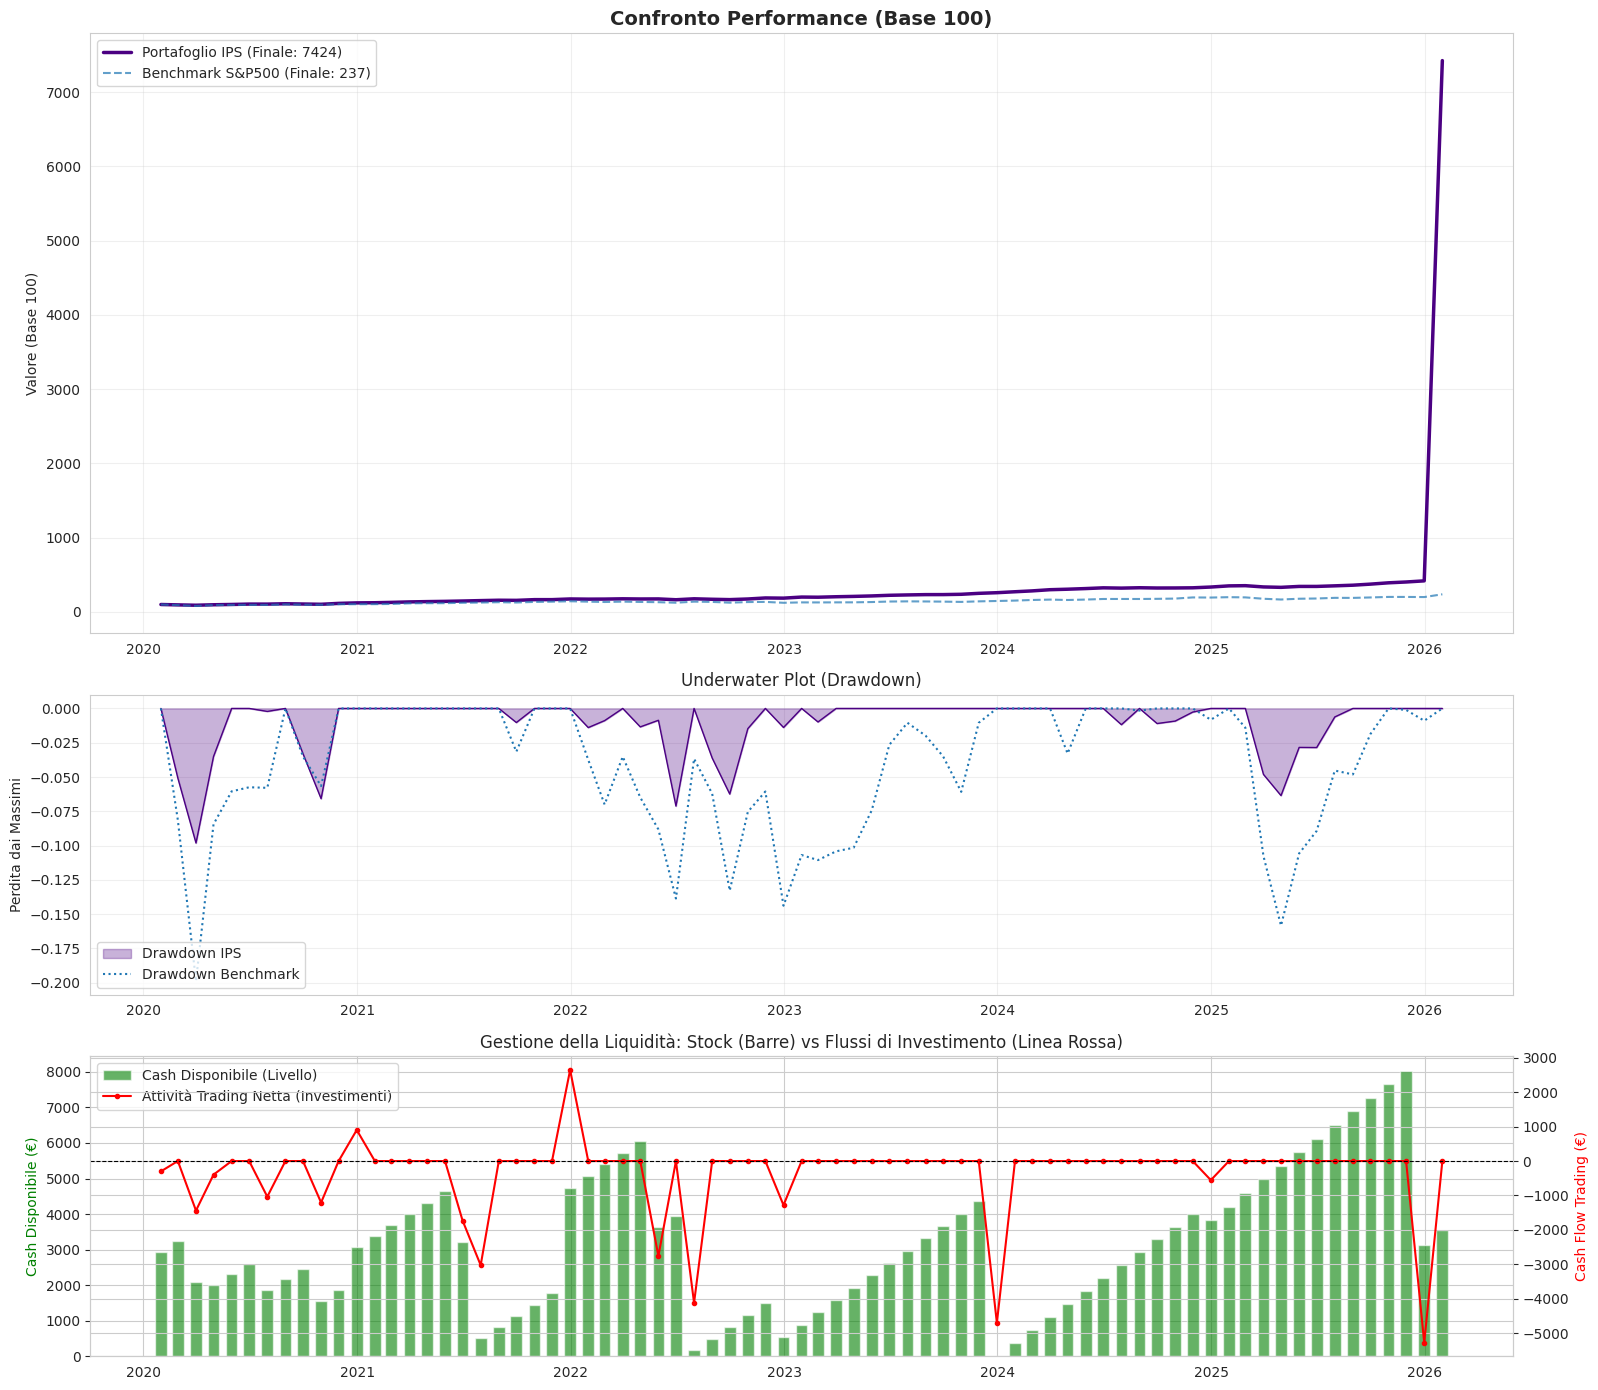

In [13]:
## BLOCCO 4: ANALISI AVANZATA, METRICHE E REPORTING GRAFICO - CORRETTO E PULITO
df_holdings = df_simulazione[portafoglio].copy()
df_weights = pd.DataFrame(index=df_simulazione.index, columns=portafoglio)

for date in df_simulazione.index:
    current_shares = df_holdings.loc[date]
    current_prices = dati_stocks_monthly.loc[date]

    market_values = current_shares * current_prices
    total_invested_value = market_values.sum()

    if total_invested_value > 0:
        df_weights.loc[date] = market_values / total_invested_value
    else:
        df_weights.loc[date] = 0.0


#print("df_holdings created successfully, displaying the first 5 rows:")
#print(df_holdings.head())
#print("df_weights created successfully, displaying the first 5 rows (in percentage):")
#print((df_weights.head() * 100).round(2))

# --- 1. PREPARAZIONE DATI ---

# Benchmark: Calcolo rendimenti mensili del S&P500
prices_bmk = dati_monthly[benchmark_ticker] # Changed to use dati_monthly which now includes benchmark
# Allineamento date: prendiamo solo le date presenti nella simulazione
bmk_aligned = prices_bmk.loc[df_simulazione.index].dropna()
r_bmk = bmk_aligned.pct_change().fillna(0) # Rendimenti mensili benchmark

# Portafoglio IPS: Calcolo rendimenti mensili
# Nota: Per Alpha e Beta usiamo i rendimenti del Valore Totale del portafoglio
r_ips = df_simulazione['Total_Value'].pct_change().fillna(0)

# Allineamento finale per sicurezza (intersezione indici)
common_idx = r_ips.index.intersection(r_bmk.index)
r_ips_sync = r_ips.loc[common_idx]
r_bmk_sync = r_bmk.loc[common_idx]

# --- 2. CALCOLO METRICHE (Alpha, Beta, Drawdown) ---

def calculate_advanced_metrics(returns_ptf, returns_bmk, risk_free_annual=0.02):
    # Annualizzazione
    rf_monthly = risk_free_annual / 12
    n_months = len(returns_ptf)
    ann_factor = 12

    # 1. CAGR (Rendimento Annuo Composto)
    cum_ret = (1 + returns_ptf).prod()
    cagr = cum_ret ** (1 / (n_months/12)) - 1

    # 2. Volatilità Annualizzata
    vol = returns_ptf.std() * np.sqrt(ann_factor)

    # 3. Sharpe Ratio
    sharpe = (cagr - risk_free_annual) / vol if vol != 0 else 0

    # 4. Beta (Slope della regressione lineare)
    # Covarianza(Ptf, Bmk) / Varianza(Bmk)
    covariance = np.cov(returns_ptf, returns_bmk)[0, 1]
    variance_bmk = np.var(returns_bmk)
    beta = covariance / variance_bmk if variance_bmk != 0 else 1

    # 5. Alpha (Jensen's Alpha)
    # Alpha = Rp - [Rf + Beta * (Rm - Rf)]
    # Calcoliamo su base annua
    mean_ret_ptf_ann = returns_ptf.mean() * 12
    mean_ret_bmk_ann = returns_bmk.mean() * 12
    alpha = mean_ret_ptf_ann - (risk_free_annual + beta * (mean_ret_bmk_ann - risk_free_annual))

    # 6. Max Drawdown (su Wealth Index)
    wealth_index = (1 + returns_ptf).cumprod()
    peak = wealth_index.expanding(min_periods=1).max()
    dd = (wealth_index - peak) / peak
    max_dd = dd.min()

    return {
        "CAGR": cagr,
        "Volatilità": vol,
        "Sharpe": sharpe,
        "Beta": beta,
        "Alpha": alpha,
        "MaxDD": max_dd
    }

metrics_ips = calculate_advanced_metrics(r_ips_sync, r_bmk_sync)
metrics_bmk = calculate_advanced_metrics(r_bmk_sync, r_bmk_sync) # Beta sarà 1, Alpha 0

# Aggiunta della colonna 'Invested_Capital'
# Calcola il capitale investito cumulativo sommando il cash iniziale e gli apporti mensili effettivi
df_simulazione['Invested_Capital'] = cash_iniziale + df_simulazione['Monthly_Add'].cumsum()

# --- 3. REPORT TESTUALE ---

print(f"\n{'='*70}")
print(f"REPORT PERFORMANCE AVANZATO (Periodo: {df_simulazione.index[0].date()} - {df_simulazione.index[-1].date()})")
print(f"{'='*70}")

# Sezione 1: Valori Assoluti
print(f"\n[SITUAZIONE PATRIMONIALE]")
print(f"Capitale Versato Totale:  € {df_simulazione['Invested_Capital'].iloc[-1]:,.2f}")
profit = df_simulazione['Total_Value'].iloc[-1] - df_simulazione['Invested_Capital'].iloc[-1]
print(f"Valore Finale Portafoglio: € {df_simulazione['Total_Value'].iloc[-1]:,.2f}")
print(f"Cash disponibile:          € {df_simulazione['Cash'].iloc[-1]:,.2f}")
print(f"Dividendi reinvestiti:     € {df_simulazione['Total_Reinvested_Dividends'].iloc[-1]:,.2f}")
print(f"Profitto Netto:            € {profit:,.2f} ({profit/df_simulazione['Invested_Capital'].iloc[-1]:.2%})")

# Sezione 2: Tabella Metriche
print(f"\n[INDICATORI DI PERFORMANCE E RISCHIO]")
headers = ["Metrica", "Portafoglio IPS", "Benchmark (S&P500)"]
row_fmt = "{:<25} {:<25} {:<25}"
print("-" * 75)
print(row_fmt.format(*headers))
print("-" * 75)
print(row_fmt.format("Rendimento Annuo (CAGR)", f"{metrics_ips['CAGR']:.2%}", f"{metrics_bmk['CAGR']:.2%}" ))
print(row_fmt.format("Volatilità (Rischio)", f"{metrics_ips['Volatilità']:.2%}", f"{metrics_bmk['Volatilità']:.2%}" ))
print(row_fmt.format("Max Drawdown", f"{metrics_ips['MaxDD']:.2%}", f"{metrics_bmk['MaxDD']:.2%}" ))
print(row_fmt.format("Sharpe Ratio", f"{metrics_ips['Sharpe']:.2f}", f"{metrics_bmk['Sharpe']:.2f}" ))
print("-" * 75)
print(row_fmt.format("BETA (Sensibilità)", f"{metrics_ips['Beta']:.2f}", "1.00" ))
print(row_fmt.format("ALPHA (Extra-Rendimento)", f"{metrics_ips['Alpha']:.2%}", "0.00%" ))
print("-" * 75)

# Calculate final actual asset class weights
final_ac_weights = {ac: 0.0 for ac in target_ac_weights.keys() if 'Cash' not in ac}
final_weights_only_assets = df_weights.iloc[-1] # Exclude benchmark for AC calc

for ticker, weight in final_weights_only_assets.items():
    ac_name = asset_class_map.get(ticker)
    if ac_name: # Ensure the asset class is in our target_ac_weights
        final_ac_weights[ac_name] += float(weight)

# Sezione 3: Pesi delle Asset Class
print(f"\n[PESI DELLE ASSET CLASS (Target vs. Finale)]")
print("-" * 60)
print(f"{'Asset Class':<15} {'Target Weight':<15} {'Final Actual':<15} {'Deviation':<15}")
print("-" * 60)
for ac, target_w in target_ac_weights.items():
   if 'Cash' not in ac: # Exclude cash for this comparison, as cash is dynamic
        final_w = final_ac_weights.get(ac, 0.0)
        deviation = final_w - target_w
        print(f"{ac:<15} {target_w:.2%}{'':<4} {final_w:.2%}{'':<7} {deviation:.2%}")
print("-" * 60)

# Sezione 4: Pesi dei singoli titoli a fine periodo
print(f"\n[PESI DEI SINGOLI TITOLI A FINE PERIODO]")
final_weights_display = df_weights.iloc[-1] # Ensure benchmark is not included if present
for ticker, weight in final_weights_display.items():
    print(f"- {ticker:<10}: {weight:.2%}")


# --- 4. GRAFICI ---

# Creiamo una figura con 3 sottografici (2 per performance, 1 per cash)
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

# Grafico 1: Performance Comparata (Base 100)
ax1 = fig.add_subplot(gs[0])
ips_base100 = (1 + r_ips_sync).cumprod() * 100
bmk_base100 = (1 + r_bmk_sync).cumprod() * 100

ax1.plot(ips_base100.index, ips_base100, label=f'Portafoglio IPS (Finale: {ips_base100.iloc[-1]:.0f})', color='#4b0082', linewidth=2.5)
ax1.plot(bmk_base100.index, bmk_base100, label=f'Benchmark S&P500 (Finale: {bmk_base100.iloc[-1]:.0f})', color='#1f77b4', linestyle='--', alpha=0.7)
ax1.set_title('Confronto Performance (Base 100)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valore (Base 100)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Grafico 2: Drawdown Sottomarino
ax2 = fig.add_subplot(gs[1], sharex=ax1)
# Calcolo drawdown per grafico
dd_ips = (ips_base100 / ips_base100.expanding(min_periods=1).max()) - 1
dd_bmk = (bmk_base100 / bmk_base100.expanding(min_periods=1).max()) - 1

ax2.fill_between(dd_ips.index, dd_ips, 0, color='#4b0082', alpha=0.3, label='Drawdown IPS')
ax2.plot(dd_ips.index, dd_ips, color='#4b0082', linewidth=1)
ax2.plot(dd_bmk.index, dd_bmk, color='#1f77b4', linestyle=':', label='Drawdown Benchmark')
ax2.set_title('Underwater Plot (Drawdown)', fontsize=12)
ax2.set_ylabel('Perdita dai Massimi')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

# Grafico 3: Analisi della Liquidità (Cash Flow e Livello Cash)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Usiamo un grafico a barre combinato
# Barre: Livello di Cash disponibile a fine mese
bars = ax3.bar(df_simulazione.index, df_simulazione['Cash'], width=20, color='green', alpha=0.6, label='Cash Disponibile (Livello)')

# Linea: Cash Flow Mensile (Differenza di cash rispetto al mese prima, al netto dell'apporto)
# Nota: Cash Flow = Cash_Oggi - Cash_Ieri.
# Se scende molto sotto zero significa che abbiamo investito pesantemente.
cash_diff = df_simulazione['Cash'].diff().fillna(0)
# Sottraiamo l'apporto mensile effettivo per vedere l'attività di trading netta
trading_activity = cash_diff - df_simulazione['Monthly_Add']

# Asse secondario per l'attività di trading (acquisti/vendite)
ax3_bis = ax3.twinx()
ax3_bis.plot(df_simulazione.index, trading_activity, color='red', linestyle='-', linewidth=1.5, marker='o', markersize=3, label='Attività Trading Netta (Investimenti)')
# Aggiungiamo una linea dello zero per l'attività di trading
ax3_bis.axhline(0, color='black', linewidth=0.8, linestyle='--')

ax3.set_title('Gestione della Liquidità: Stock (Barre) vs Flussi di Investimento (Linea Rossa)', fontsize=12)
ax3.set_ylabel('Cash Disponibile (€)', color='green')
ax3_bis.set_ylabel('Cash Flow Trading (€)', color='red')

# Creazione legenda unica per i due assi
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_bis.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

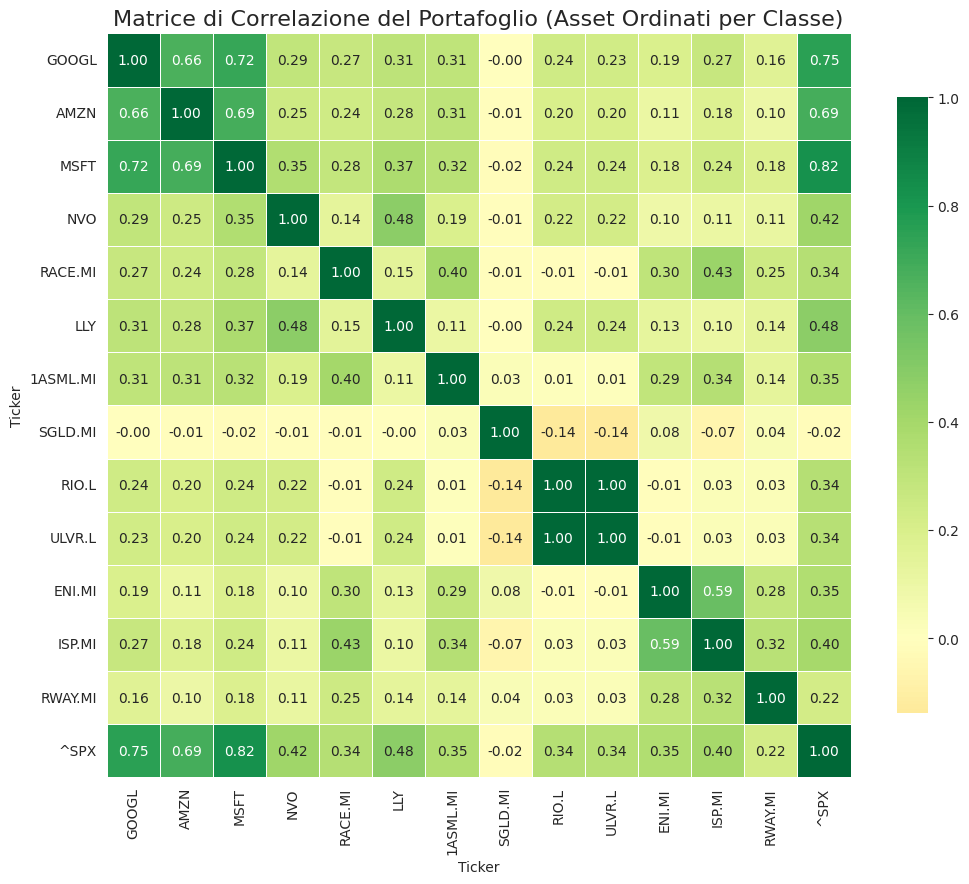


Correlazione media tra il blocco GROWTH e il blocco VALUE: 0.2556


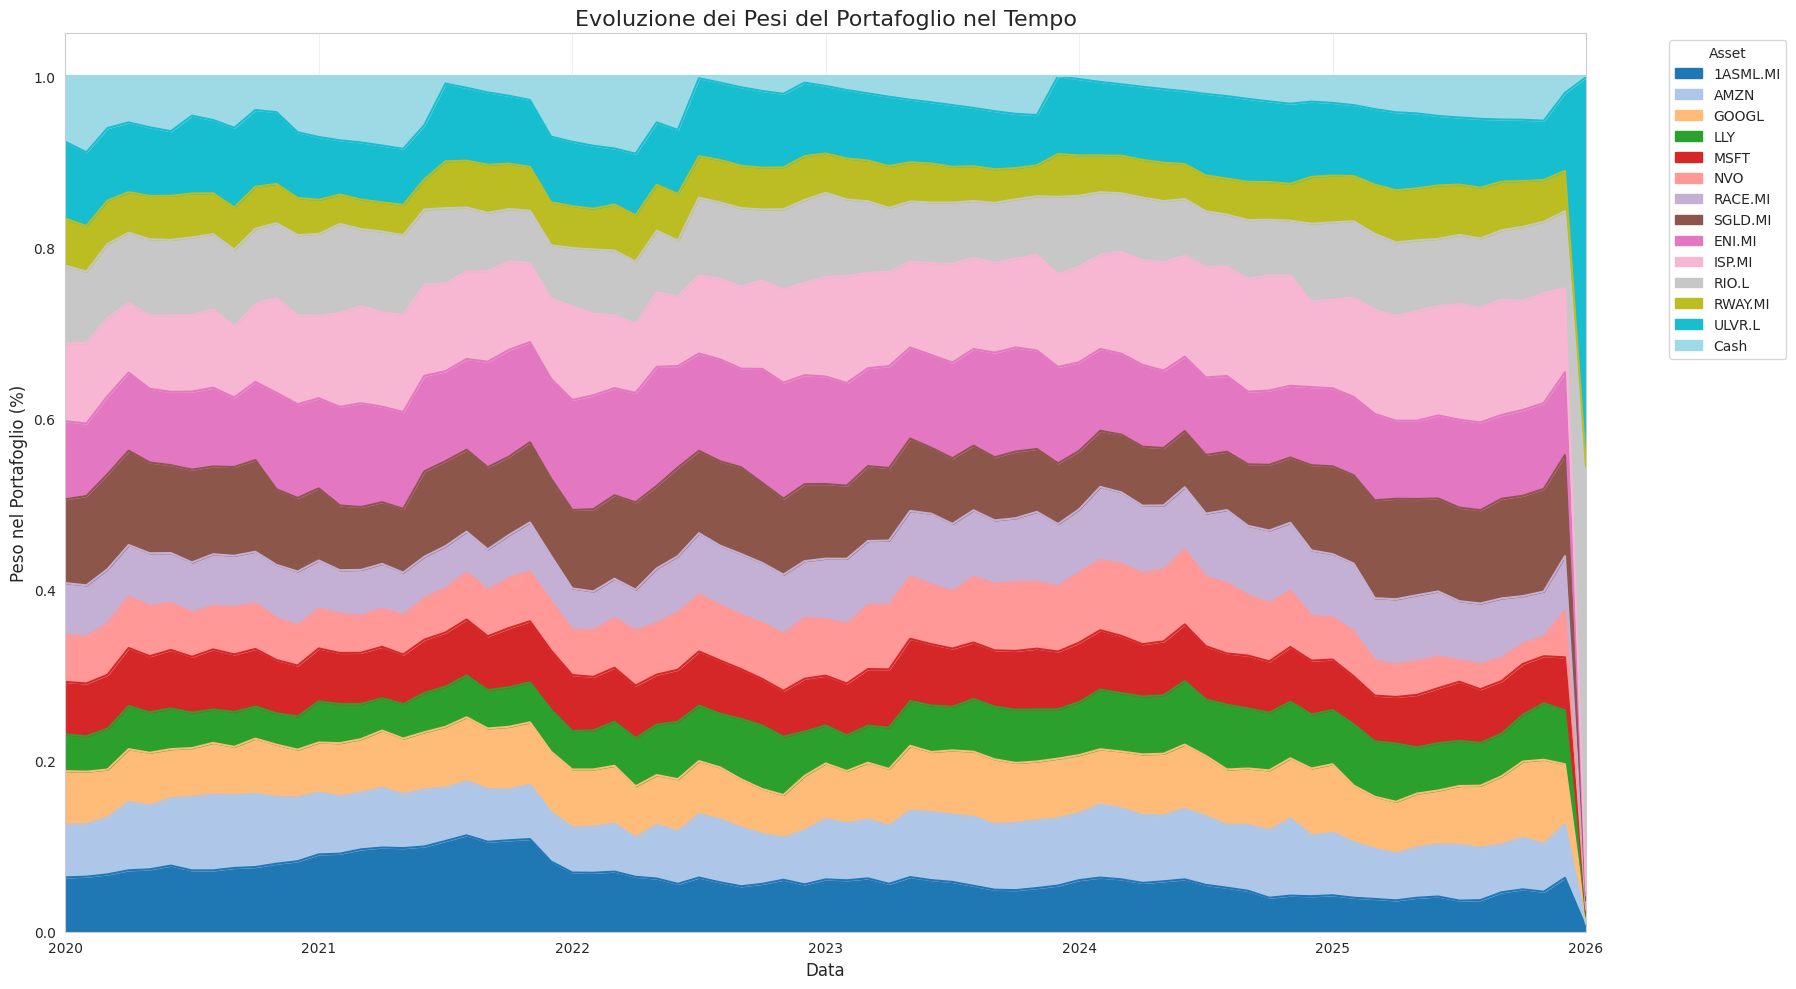

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- BLOCCO 5 : ANALISI DELLA CORRELAZIONE --- CORRETTO

# 1. Calcolo dei rendimenti giornalieri
rendimenti = dati_ptf_final.pct_change().dropna()

# 2. Ordiniamo i ticker per Asset Class per vedere i "blocchi" nella matrice
# Creiamo una lista ordinata basata sulla classe definita in 'assets'
tickers_ordinati = sorted(portafoglio, key=lambda x: asset_class_map[x])
if benchmark_ticker in rendimenti.columns:
    tickers_ordinati += [benchmark_ticker]

# 3. Calcolo della matrice di correlazione (Metodo Pearson)
corr_matrix = rendimenti[tickers_ordinati].corr()

# 4. Visualizzazione con Heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Maschera per la parte superiore

sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='RdYlGn',
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matrice di Correlazione del Portafoglio (Asset Ordinati per Classe)', fontsize=16)
plt.show()

# 5. Calcolo Correlazione Media tra i Gruppi (Growth vs Value)
growth_tickers = [t for t in portafoglio if asset_class_map[t] == 'Growth']
value_tickers = [t for t in portafoglio if asset_class_map[t] == 'Value']

if growth_tickers and value_tickers:
    corr_inter_class = rendimenti[growth_tickers].mean(axis=1).corr(rendimenti[value_tickers].mean(axis=1))
    print(f"\nCorrelazione media tra il blocco GROWTH e il blocco VALUE: {corr_inter_class:.4f}")


# --- BLOCCO: EVOLUZIONE DEI PESI DEL PORTAFOGLIO NEL TEMPO ---

# 1. Estrai i pesi individuali e calcola il peso del cash dal df_simulazione aggiornato
# Converti la colonna 'Individual_Weights' (che contiene dizionari) in un DataFrame espanso
df_portfolio_weights_assets = pd.DataFrame(df_simulazione['Individual_Weights'].tolist(), index=df_simulazione.index)

# Calcola il peso del cash rispetto al Total_Value del portafoglio
df_portfolio_weights_assets['Cash'] = df_simulazione['Cash'] / df_simulazione['Total_Value']

# Ordina le colonne per raggruppare le asset class nel plot (opzionale, per chiarezza visiva)
# Per fare ciò, potremmo voler creare un ordine basato sulla 'asset_class_map'
# Ottieni l'ordine delle asset class (es. Growth, Value, Hedge) e poi ordina i ticker al loro interno
ordered_tickers_in_ac = []
for ac in sorted(target_ac_weights.keys()):
    if ac != 'Cash_Min' and ac != 'Cash_Max': # Cash sarà una colonna separata
        ordered_tickers_in_ac.extend(sorted([t for t in portafoglio if asset_class_map.get(t) == ac]))

# Aggiungi 'Cash' come ultima colonna per coerenza visiva
ordered_columns = ordered_tickers_in_ac + ['Cash']

# Assicurati che tutte le colonne ordinate esistano nel DataFrame e riordinale
df_portfolio_weights = df_portfolio_weights_assets[ordered_columns]

# 2. Visualizzazione con Stacked Area Plot
plt.figure(figsize=(18, 10))
ax = plt.gca()

# Usa un colormap con abbastanza colori distinti per tutti gli asset + cash
# 'tab20' ha 20 colori, 'tab20b' e 'tab20c' ne aggiungono altri.
# Se hai più di 20 asset+cash, potresti dover ciclare o usare un cmap continuo.
num_colors = len(df_portfolio_weights.columns)
if num_colors <= 20:
    cmap = 'tab20'
elif num_colors <= 40:
    cmap = 'tab20b'
else:
    cmap = 'viridis' # Fallback a un colormap continuo

df_portfolio_weights.plot(kind='area', stacked=True, ax=ax, cmap=cmap)

plt.title('Evoluzione dei Pesi del Portafoglio nel Tempo', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Peso nel Portafoglio (%)', fontsize=12)
plt.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
#---- BLOCCO 6 - ANALISI PER PERIODO ---- CORRETTTO


print("\n--- Detailed Period-by-Period Report ---")
print("Each period includes NAV, Cash, Liquidity Status, Market Context, Individual Stock Weights, and Asset Class Weights.\n")

# To avoid excessive output, print only the first few and last few periods
def print_detailed_report(df, num_periods=0):
    print_count = 0
    if num_periods == 0: num_periods = len(df)
    for index, row in df.iterrows():
        if print_count < num_periods or print_count >= len(df) - num_periods:
            print(f"Date: {index.date()}")
            print(f"  NAV: {row['Total_Value']:.2f}")
            print(f"  Cash: {row['Cash']:.2f} ({(row['Cash'] * 100 / row['Total_Value']):.2f}% )")
            print(f"  Liquidity Status: {row['Liquidity_Status']}")
            print(f"  Market Bonus: {row['Growth_Bonus']:.2f}")
            print(f"  Euphoria Mode: {row['Euphoria_Mode']}")
            print("  Individual Weights:")
            for ticker, weight in row['Individual_Weights'].items(): # Corrected loop syntax
                stock_value = row['Asset_Value'].get(ticker, 0) # Get value using ticker, with default 0 if missing
                qty = row['Individual_Qty'].get(ticker, 0) # Get quantity using ticker, with default 0 if missing
                print(f"    {ticker}: Shares Number = {qty:.2f} , Asset Value = {stock_value:.2f} EUR , Weight = {weight:.2%}")
            print("  Asset Class Weights:")
            for ac, weight in row['Asset_Class_Weights'].items():
                # Filter out Cash from Asset Class Weights for display if it's not a real asset class
                if ac != 'Cash':
                    print(f"    {ac}: {weight:.2%}")

            if row['Per_Stock_Net_Dividends'] and len(row['Per_Stock_Net_Dividends']) > 0:
                print("  Annual Dividends (Net after tax) and Yields:")
                total_annual_net_dividend = 0.0
                for stock, div_amount in row['Per_Stock_Net_Dividends'].items():
                    yield_val = row['Per_Stock_Current_Yields'].get(stock, 0.0)
                    total_annual_net_dividend += div_amount
                    print(f"    {stock}: Net Dividend = {div_amount:.2f} EUR, Annual Yield = {yield_val:.2%}")
                print(f"    Total Annual Net Dividend: {total_annual_net_dividend:.2f} EUR")
            print("-" * 40)
        print_count += 1
    if len(df) > 2 * num_periods:
        print(f"\n... (Skipping {len(df) - 2 * num_periods} intermediate periods) ...\n")
        print(f"--- End of Detailed Period-by-Period Report (showing last {num_periods} periods) ---")

print_detailed_report(df_simulazione)


--- Detailed Period-by-Period Report ---
Each period includes NAV, Cash, Liquidity Status, Market Context, Individual Stock Weights, and Asset Class Weights.

Date: 2020-01-31
  NAV: 38300.00
  Cash: 2937.86 (7.67% )
  Liquidity Status: INITIAL_DEPLOY
  Market Bonus: 0.00
  Euphoria Mode: False
  Individual Weights:
    GOOGL: Shares Number = 37.00 , Asset Value = 2385.29 EUR , Weight = 6.23%
    AMZN: Shares Number = 26.00 , Asset Value = 2367.67 EUR , Weight = 6.18%
    MSFT: Shares Number = 16.00 , Asset Value = 2344.78 EUR , Weight = 6.12%
    NVO: Shares Number = 84.00 , Asset Value = 2081.04 EUR , Weight = 5.43%
    RACE.MI: Shares Number = 16.00 , Asset Value = 2343.26 EUR , Weight = 6.12%
    LLY: Shares Number = 14.00 , Asset Value = 1649.04 EUR , Weight = 4.31%
    RIO.L: Shares Number = 72.00 , Asset Value = 3471.87 EUR , Weight = 9.06%
    ULVR.L: Shares Number = 60.00 , Asset Value = 3443.35 EUR , Weight = 8.99%
    ENI.MI: Shares Number = 413.00 , Asset Value = 3495.18 E

In [16]:
# Calcolo della volatilità annuale e trimestrale per ogni titolo

# 1. Calcola i rendimenti giornalieri per ogni titolo
stock_returns = dati_ptf_final[nomi_asset].pct_change().dropna()

# Costanti di annualizzazione
# Ci sono circa 252 giorni di trading in un anno e 63 in un trimestre.
DAYS_IN_YEAR = 252
DAYS_IN_QUARTER = DAYS_IN_YEAR / 4  # circa 63

# Dizionari per salvare le volatilità
annual_volatilities = {}
quarterly_volatilities = {}

# 2. Calcola la volatilità per ogni titolo
for ticker in nomi_asset:
    # Volatilità giornaliera (deviazione standard dei rendimenti giornalieri)
    daily_volatility = stock_returns[ticker].std()

    # Volatilità annuale (giornaliera * sqrt(giorni di trading nell'anno))
    annual_vol = daily_volatility * (DAYS_IN_YEAR ** 0.5)
    annual_volatilities[ticker] = annual_vol

    # Volatilità trimestrale (giornaliera * sqrt(giorni di trading nel trimestre))
    quarterly_vol = daily_volatility * (DAYS_IN_QUARTER ** 0.5)
    quarterly_volatilities[ticker] = quarterly_vol

# 3. Visualizza i risultati dei singoli titoli
print("\n--- Volatilità dei singoli titoli ---")
print("--------------------------------------")
print(f"{'Ticker':<10} {'Volatilità Annuale':<20} {'Volatilità Trimestrale':<25}")
print("--------------------------------------")
for ticker in nomi_asset:
    print(f"{ticker:<10} {annual_volatilities[ticker]:<19.2%} {quarterly_volatilities[ticker]:<24.2%}")
print("--------------------------------------")

# 4. Calcolo della volatilità complessiva del portafoglio (con pesi target) con formula di covarianza

# Assicurati che i pesi siano una Series di Pandas, allineata con i nomi degli asset
weights_series = pd.Series(pesi_portafoglio_attuale, index=nomi_asset)

# Calcola la matrice di covarianza dei rendimenti giornalieri
daily_covariance_matrix = stock_returns[nomi_asset].cov()

# Annualizza la matrice di covarianza (moltiplica per i giorni di trading nell'anno)
annual_covariance_matrix = daily_covariance_matrix * DAYS_IN_YEAR

# Converti i pesi in un array numpy e assicurati che sia un vettore colonna per il calcolo matriciale
weights_np = weights_series.values.reshape(-1, 1)

# Calcola la varianza del portafoglio: w^T * Sigma * w
portfolio_variance_annual = np.dot(weights_np.T, np.dot(annual_covariance_matrix, weights_np))[0][0]

# Calcola la volatilità annuale del portafoglio (deviazione standard)
portfolio_annual_volatility_cov = np.sqrt(portfolio_variance_annual)

# Per la volatilità trimestrale, possiamo usare la stessa logica o dividerla per sqrt(4) dalla annuale
portfolio_quarterly_volatility_cov = portfolio_annual_volatility_cov / np.sqrt(4) # Approssimazione

print("\n--- Volatilità Complessiva del Portafoglio (con Pesi Target e Covarianza) ---")
print("---------------------------------------------------------------------------------")
print(f"Volatilità Annuale del Portafoglio: {portfolio_annual_volatility_cov:.2%}")
print(f"Volatilità Trimestrale del Portafoglio: {portfolio_quarterly_volatility_cov:.2%}")
print("---------------------------------------------------------------------------------")


--- Volatilità dei singoli titoli ---
--------------------------------------
Ticker     Volatilità Annuale   Volatilità Trimestrale   
--------------------------------------
GOOGL      34.63%              17.32%                  
AMZN       37.74%              18.87%                  
MSFT       32.21%              16.10%                  
NVO        36.88%              18.44%                  
RACE.MI    28.29%              14.14%                  
LLY        36.05%              18.03%                  
RIO.L      3482.02%            1741.01%                
ULVR.L     3593.71%            1796.86%                
ENI.MI     30.08%              15.04%                  
ISP.MI     31.07%              15.54%                  
RWAY.MI    23.32%              11.66%                  
SGLD.MI    15.49%              7.75%                   
1ASML.MI   39.46%              19.73%                  
--------------------------------------

--- Volatilità Complessiva del Portafoglio (con Pesi Targ

In [17]:
!pip install streamlit
import streamlit as st
import plotly.graph_objects as go

st.title("Financial Analysis Dashboard 📈")

# --- Placeholder for df (replace with actual data loading) ---
# This 'df' needs to be defined from your data, for example:
# df = yf.download(ticker, period=f'{periodo}y')['Close']
# For demonstration purposes, let's create a dummy DataFrame that matches the expected structure.
import pandas as pd
import numpy as np

# Dummy data for demonstration
# In a real scenario, 'df' would come from your data fetching logic (e.g., yfinance)
if 'df' not in locals():
    dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    data = {
        'Date': dates,
        'Open': np.random.rand(100) * 100 + 100,
        'High': np.random.rand(100) * 100 + 150,
        'Low': np.random.rand(100) * 100 + 50,
        'Close': np.random.rand(100) * 100 + 100
    }
    df = pd.DataFrame(data)

# Form nel sidebar per inserimento dati
with st.sidebar:
    ticker = st.text_input("Inserisci Ticker (es. AAPL)", value="AAPL")
    periodo = st.slider("Anni di analisi", 1, 10, 5)

# Plot grafico ad alto impatto
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Close'])])
fig.update_layout(template="plotly_dark") # Estetica dark finanziaria
st.plotly_chart(fig, use_container_width=True)

2026-02-01 20:17:42.160 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.161 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.162 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-01 20:17:42.171 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [18]:
import os

# Define the content of your Streamlit app from cell o0SvpXEhggfa
streamlit_code = ''''
import streamlit as st
import plotly.graph_objects as go
import pandas as pd
import numpy as np

st.title("Financial Analysis Dashboard 📈")

# Dummy data for demonstration
# In a real scenario, 'df' would come from your data fetching logic (e.g., yfinance)
if 'df' not in st.session_state:
    dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    data = {
        'Date': dates,
        'Open': np.random.rand(100) * 100 + 100,
        'High': np.random.rand(100) * 100 + 150,
        'Low': np.random.rand(100) * 100 + 50,
        'Close': np.random.rand(100) * 100 + 100
    }
    st.session_state.df = pd.DataFrame(data)

df = st.session_state.df

# Form nel sidebar per inserimento dati
with st.sidebar:
    ticker = st.text_input("Inserisci Ticker (es. AAPL)", value="AAPL")
    periodo = st.slider("Anni di analisi", 1, 10, 5)

# Plot grafico ad alto impatto
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Close'])])
fig.update_layout(template="plotly_dark") # Estetica dark finanziaria
st.plotly_chart(fig, use_container_width=True)
'''

# Write the code to a file
with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit app code saved to app.py")


Streamlit app code saved to app.py
